<a href="https://colab.research.google.com/github/dslwa/BASICS_OF_AI/blob/main/SztucznaInteligencja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow opencv-python matplotlib

In [ ]:
import os

print("Bieżący katalog roboczy:", os.getcwd())
print("Zawartość katalogu:", os.listdir())



Bieżący katalog roboczy: /content
Zawartość katalogu: ['.config', 'drive', 'sample_data']


In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [ ]:
import os
import numpy as np
import cv2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from scipy.spatial.distance import directed_hausdorff

# Parametry
IMG_HEIGHT = 528
IMG_WIDTH = 632

# Metryki
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = tf.keras.backend.flatten(tf.cast(y_pred, tf.float32))
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou_metric(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = tf.keras.backend.flatten(tf.cast(tf.round(y_pred), tf.float32))
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def tversky_index(y_true, y_pred, alpha=0.5, beta=0.5, smooth=1):
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = tf.keras.backend.flatten(tf.cast(tf.round(y_pred), tf.float32))
    TP = tf.keras.backend.sum(y_true_f * y_pred_f)
    FP = tf.keras.backend.sum((1 - y_true_f) * y_pred_f)
    FN = tf.keras.backend.sum(y_true_f * (1 - y_pred_f))
    return (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)

# Hausdorff Distance
def hausdorff_distance(true_mask, pred_mask):
    true_coords = np.argwhere(true_mask > 0.5)
    pred_coords = np.argwhere(pred_mask > 0.5)
    if true_coords.size == 0 or pred_coords.size == 0:
        return np.nan
    return max(directed_hausdorff(true_coords, pred_coords)[0],
               directed_hausdorff(pred_coords, true_coords)[0])

# Wczytywanie obrazów
def load_images_and_masks(img_dir, mask_dir):
    image_files = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith(".bmp")])
    mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(".bmp")])

    images = []
    masks = []

    for img_path, mask_path in zip(image_files, mask_files):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
        images.append(img / 255.0)
        masks.append(1.0 - (mask / 255.0))

    X = np.expand_dims(np.array(images), axis=-1)
    y = np.expand_dims(np.array(masks), axis=-1)
    return X, y

# Ścieżki
base_path = '/content/drive/MyDrive/Sztuczna_Inteligencja'
train_img = os.path.join(base_path, 'Train/img')
train_mask = os.path.join(base_path, 'Train/mask')
val_img = os.path.join(base_path, 'validate/img')
val_mask = os.path.join(base_path, 'validate/mask')
test_img = os.path.join(base_path, 'test/img')
test_mask = os.path.join(base_path, 'test/mask')

X_train, y_train = load_images_and_masks(train_img, train_mask)
X_val, y_val = load_images_and_masks(val_img, val_mask)
X_test, y_test = load_images_and_masks(test_img, test_mask)

# Model
def unet_model(input_shape):
    inputs = Input(input_shape)

    # Down
    c1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    # Bottleneck
    b = Conv2D(128, 3, activation='relu', padding='same')(p2)
    b = Conv2D(128, 3, activation='relu', padding='same')(b)

    # Up
    u2 = Conv2DTranspose(64, 2, strides=2, padding='same')(b)
    u2 = concatenate([u2, c2])
    c3 = Conv2D(64, 3, activation='relu', padding='same')(u2)
    c3 = Conv2D(64, 3, activation='relu', padding='same')(c3)

    u1 = Conv2DTranspose(32, 2, strides=2, padding='same')(c3)
    u1 = concatenate([u1, c1])
    c4 = Conv2D(32, 3, activation='relu', padding='same')(u1)
    c4 = Conv2D(32, 3, activation='relu', padding='same')(c4)

    outputs = Conv2D(1, 1, activation='sigmoid')(c4)
    return Model(inputs, outputs)

# Kompilacja
model = unet_model((IMG_HEIGHT, IMG_WIDTH, 1))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[dice_coef, iou_metric, tversky_index])

# Checkpoint
checkpoint_cb = ModelCheckpoint(
    "best_model.h5",
    monitor='val_dice_coef',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Trening
model.summary()
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=4,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_cb]
)

model.save("unet_final.h5")
model.save("unet_saved_model.keras")
model.export("unet_saved_model")

print("Model zapisany jako 'unet_final.h5' i w folderze 'unet_saved_model'")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 528, 632,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 528, 632,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 528, 632,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 264, 316,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 264, 316,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 264, 316,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 132, 158,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 132, 158,  │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 132, 158,  │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 264, 316,  │     32,832 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 264, 316,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 264, 316,  │     73,792 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 264, 316,  │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 528, 632,  │      8,224 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 528, 632,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 528, 632,  │     18,464 │ concatenate_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 528, 632,  │      9,248 │ conv2d_8[0][0]  

 Total params: 465,953 (1.78 MB)

 Trainable params: 465,953 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - dice_coef: 0.0792 - iou_metric: 0.0463 - loss: 0.1491 - tversky_index: 0.0619
Epoch 1: val_dice_coef improved from -inf to 0.70290, saving model to best_model.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 86s 436ms/step - dice_coef: 0.0808 - iou_metric: 0.0476 - loss: 0.1483 - tversky_index: 0.0637 - val_dice_coef: 0.7029 - val_iou_metric: 0.6604 - val_loss: 0.0018 - val_tversky_index: 0.7785
Epoch 2/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - dice_coef: 0.6688 - iou_metric: 0.6202 - loss: 0.0016 - tversky_index: 0.7627
Epoch 2: val_dice_coef improved from 0.70290 to 0.73503, saving model to best_model.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 97s 305ms/step - dice_coef: 0.6689 - iou_metric: 0.6203 - loss: 0.0016 - tversky_index: 0.7628 - val_dice_coef: 0.7350 - val_iou_metric: 0.6994 - val_loss: 0.0015 - val_tversky_index: 0.8114
Epoch 3/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - dice_coef: 0.7051 - iou_metric: 0.6533 - loss: 0.0015 - tversky_index: 0.7863
Epoch 3: val_dice_coef improved from 0.73503 to 0.74288, saving model to best_model.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 38s 278ms/step - dice_coef: 0.7050 - iou_metric: 0.6533 - loss: 0.0015 - tversky_index: 0.7863 - val_dice_coef: 0.7429 - val_iou_metric: 0.7016 - val_loss: 0.0014 - val_tversky_index: 0.8135
Epoch 4/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - dice_coef: 0.7155 - iou_metric: 0.6589 - loss: 0.0014 - tversky_index: 0.7917
Epoch 4: val_dice_coef improved from 0.74288 to 0.74998, saving model to best_model.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 41s 282ms/step - dice_coef: 0.7155 - iou_metric: 0.6589 - loss: 0.0014 - tversky_index: 0.7917 - val_dice_coef: 0.7500 - val_iou_metric: 0.7179 - val_loss: 0.0014 - val_tversky_index: 0.8271
Epoch 5/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - dice_coef: 0.7097 - iou_metric: 0.6576 - loss: 0.0014 - tversky_index: 0.7905
Epoch 5: val_dice_coef improved from 0.74998 to 0.75276, saving model to best_model.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 34s 283ms/step - dice_coef: 0.7097 - iou_metric: 0.6577 - loss: 0.0014 - tversky_index: 0.7905 - val_dice_coef: 0.7528 - val_iou_metric: 0.7124 - val_loss: 0.0014 - val_tversky_index: 0.8222
Epoch 6/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - dice_coef: 0.7148 - iou_metric: 0.6620 - loss: 0.0013 - tversky_index: 0.7940
Epoch 6: val_dice_coef improved from 0.75276 to 0.75341, saving model to best_model.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 43s 302ms/step - dice_coef: 0.7148 - iou_metric: 0.6620 - loss: 0.0013 - tversky_index: 0.7940 - val_dice_coef: 0.7534 - val_iou_metric: 0.7254 - val_loss: 0.0013 - val_tversky_index: 0.8329
Epoch 7/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - dice_coef: 0.7112 - iou_metric: 0.6580 - loss: 0.0014 - tversky_index: 0.7912
Epoch 7: val_dice_coef improved from 0.75341 to 0.75355, saving model to best_model.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 34s 282ms/step - dice_coef: 0.7113 - iou_metric: 0.6581 - loss: 0.0014 - tversky_index: 0.7912 - val_dice_coef: 0.7536 - val_iou_metric: 0.7251 - val_loss: 0.0013 - val_tversky_index: 0.8328
Epoch 8/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - dice_coef: 0.7276 - iou_metric: 0.6751 - loss: 0.0013 - tversky_index: 0.8040
Epoch 8: val_dice_coef improved from 0.75355 to 0.76779, saving model to best_model.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 43s 302ms/step - dice_coef: 0.7276 - iou_metric: 0.6751 - loss: 0.0013 - tversky_index: 0.8040 - val_dice_coef: 0.7678 - val_iou_metric: 0.7232 - val_loss: 0.0013 - val_tversky_index: 0.8311
Epoch 9/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - dice_coef: 0.7263 - iou_metric: 0.6720 - loss: 0.0013 - tversky_index: 0.8016
Epoch 9: val_dice_coef did not improve from 0.76779
121/121 ━━━━━━━━━━━━━━━━━━━━ 41s 301ms/step - dice_coef: 0.7263 - iou_metric: 0.6721 - loss: 0.0013 - tversky_index: 0.8016 - val_dice_coef: 0.7619 - val_iou_metric: 0.7277 - val_loss: 0.0013 - val_tversky_index: 0.8348
Epoch 10/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - dice_coef: 0.7272 - iou_metric: 0.6750 - loss: 0.0014 - tversky_index: 0.8038
Epoch 10: val_dice_coef did not improve from 0.76779
121/121 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - dice_coef: 0.7272 - iou_metric: 0.6750 - loss: 0.0014 - tversky_index: 0.8038 - val_dice_coef: 0.7639 - val_iou_metric: 0.7285 - val_loss: 0

Saved artifact at 'unet_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 528, 632, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 528, 632, 1), dtype=tf.float32, name=None)
Captures:
  135092044624720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135092044625296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135092044627600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135094572042000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135092044625104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135092044624336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135094572043536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135094572043728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135094572044304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135094572045264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1350

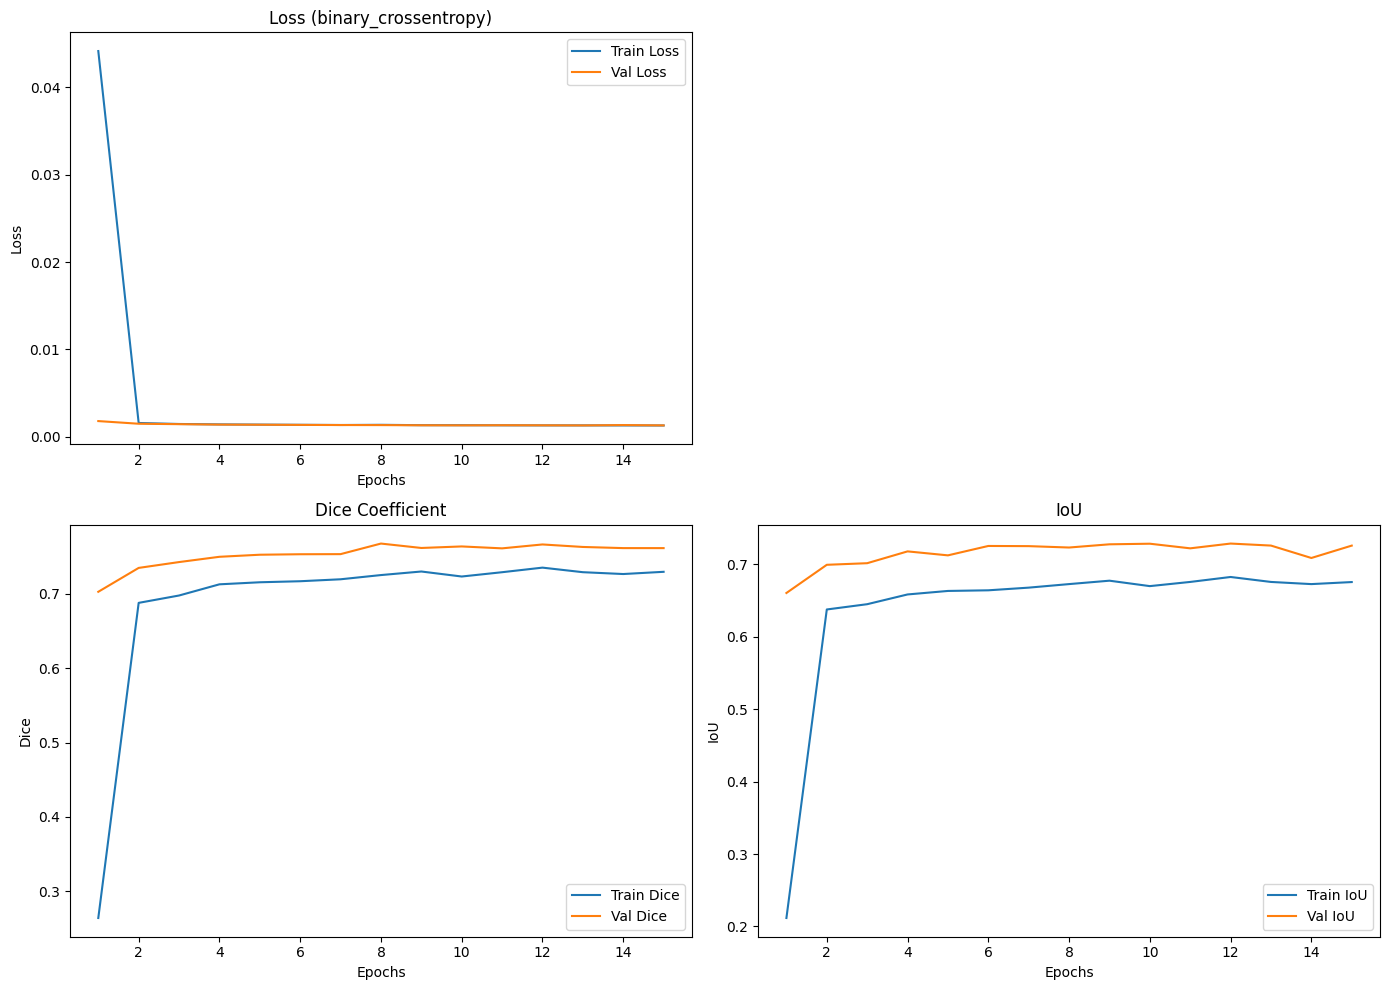

In [ ]:
# --- Wykresy strat i metryk z historii treningu ---
def plot_training_history(history):
    hist = history.history
    epochs = range(1, len(hist['loss']) + 1)

    plt.figure(figsize=(14, 10))

    # Strata
    plt.subplot(2, 2, 1)
    plt.plot(epochs, hist['loss'], label='Train Loss')
    plt.plot(epochs, hist['val_loss'], label='Val Loss')
    plt.title('Loss (binary_crossentropy)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()


    # Dice
    plt.subplot(2, 2, 3)
    plt.plot(epochs, hist['dice_coef'], label='Train Dice')
    plt.plot(epochs, hist['val_dice_coef'], label='Val Dice')
    plt.title('Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.legend()

    # IoU
    plt.subplot(2, 2, 4)
    plt.plot(epochs, hist['iou_metric'], label='Train IoU')
    plt.plot(epochs, hist['val_iou_metric'], label='Val IoU')
    plt.title('IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    plt.tight_layout()
    plt.show()

# --- Wywołanie ---
plot_training_history(history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 47s 46s/step

Test - Statystyki metryk:
Dice:    mean=0.6049, min=0.1512, max=0.8790, std=0.1501
IoU:     mean=0.5857, min=0.2502, max=1.0000, std=0.1674
Tversky: mean=0.7243, min=0.4003, max=1.0000, std=0.1377
Hausdorff: mean=77.21, min=0.00, max=600.86, std=108.30


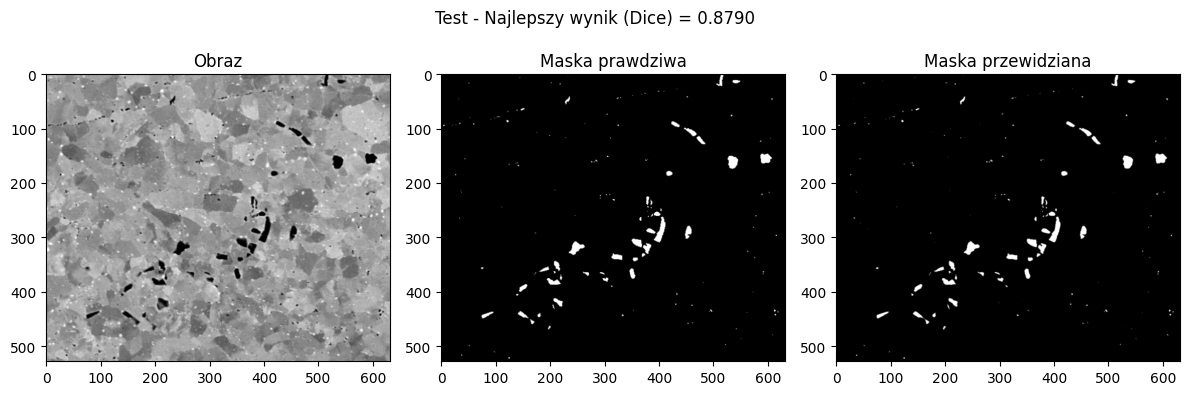

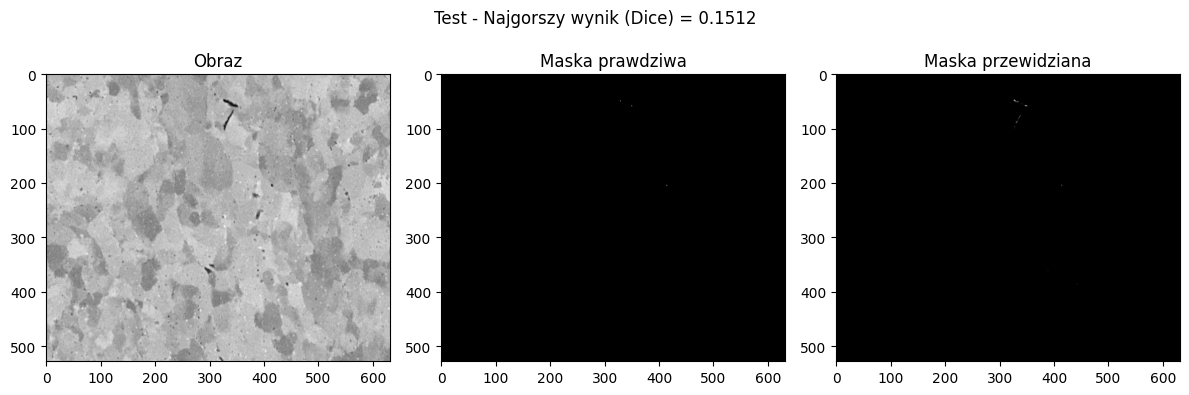

In [ ]:
def detailed_evaluation(X, y, set_name="Test"):
    y_pred = model.predict(X)

    dice_scores = []
    iou_scores = []
    tversky_scores = []
    hausdorff_scores = []

    for yt, yp in zip(y, y_pred):
        yt_mask = yt[:, :, 0]
        yp_mask = yp[:, :, 0]
        dice_scores.append(dice_coef(yt_mask, yp_mask).numpy())
        iou_scores.append(iou_metric(yt_mask, yp_mask).numpy())
        tversky_scores.append(tversky_index(yt_mask, yp_mask).numpy())
        hausdorff_scores.append(hausdorff_distance(yt_mask, yp_mask))

    print(f"\n{set_name} - Statystyki metryk:")
    print(f"Dice:    mean={np.mean(dice_scores):.4f}, min={np.min(dice_scores):.4f}, max={np.max(dice_scores):.4f}, std={np.std(dice_scores):.4f}")
    print(f"IoU:     mean={np.mean(iou_scores):.4f}, min={np.min(iou_scores):.4f}, max={np.max(iou_scores):.4f}, std={np.std(iou_scores):.4f}")
    print(f"Tversky: mean={np.mean(tversky_scores):.4f}, min={np.min(tversky_scores):.4f}, max={np.max(tversky_scores):.4f}, std={np.std(tversky_scores):.4f}")
    print(f"Hausdorff: mean={np.nanmean(hausdorff_scores):.2f}, min={np.nanmin(hausdorff_scores):.2f}, max={np.nanmax(hausdorff_scores):.2f}, std={np.nanstd(hausdorff_scores):.2f}")

    best_idx = np.argmax(dice_scores)
    worst_idx = np.argmin(dice_scores)

    for title, idx in [("Najlepszy wynik (Dice)", best_idx), ("Najgorszy wynik (Dice)", worst_idx)]:
        plt.figure(figsize=(12, 4))
        plt.suptitle(f"{set_name} - {title} = {dice_scores[idx]:.4f}")

        plt.subplot(1, 3, 1)
        plt.imshow(X[idx, :, :, 0], cmap='gray')
        plt.title('Obraz')

        plt.subplot(1, 3, 2)
        plt.imshow(y[idx, :, :, 0], cmap='gray')
        plt.title('Maska prawdziwa')

        plt.subplot(1, 3, 3)
        plt.imshow(y_pred[idx, :, :, 0], cmap='gray')
        plt.title('Maska przewidziana')

        plt.tight_layout()
        plt.show()

detailed_evaluation(X_test, y_test, "Test")

In [ ]:
import os

# Ścieżka do folderu z prawdziwymi maskami
mask_folder = "/content/drive/MyDrive/Sztuczna_Inteligencja/Testujemy/Maski"

# Pętla po plikach
for fname in os.listdir(mask_folder):
    if fname.startswith("cropped_") and fname.endswith(".bmp"):
        old_path = os.path.join(mask_folder, fname)
        new_name = f"mask_{fname}"  # dodaj "mask_" na początku
        new_path = os.path.join(mask_folder, new_name)

        os.rename(old_path, new_path)
        print(f"Zmieniono nazwę: {fname} → {new_name}")

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import load_model

# --- Parametry obrazu ---
IMG_HEIGHT = 528
IMG_WIDTH = 632

# --- Ścieżki ---
gt_folder = "/content/drive/MyDrive/Sztuczna_Inteligencja/Testujemy/Maski"
img_folder = "/content/drive/MyDrive/Sztuczna_Inteligencja/Testujemy/Obrazy"
pred_folder = "/content/drive/MyDrive/Sztuczna_Inteligencja/Testujemy/Wyniki"

os.makedirs(pred_folder, exist_ok=True)

# --- Metryki ---
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = tf.keras.backend.flatten(tf.cast(y_pred, tf.float32))
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou_metric(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = tf.keras.backend.flatten(tf.cast(tf.round(y_pred), tf.float32))
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def tversky_index(y_true, y_pred, alpha=0.5, beta=0.5, smooth=1):
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = tf.keras.backend.flatten(tf.cast(tf.round(y_pred), tf.float32))
    TP = tf.keras.backend.sum(y_true_f * y_pred_f)
    FP = tf.keras.backend.sum((1 - y_true_f) * y_pred_f)
    FN = tf.keras.backend.sum(y_true_f * (1 - y_pred_f))
    return (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)



In [ ]:

model_path = "unet_final.h5"
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Nie znaleziono modelu: {model_path}")

model = load_model(model_path, custom_objects={
    'dice_coef': dice_coef,
    'iou_metric': iou_metric,
    'tversky_index': tversky_index
})
print(f"Wczytano model z: {model_path}")

Wczytano model z: unet_final.h5


In [ ]:
img_folder = "/content/drive/MyDrive/Sztuczna_Inteligencja/Testujemy/Maski"
pred_folder = "/content/drive/MyDrive/Sztuczna_Inteligencja/Testujemy/Wyniki"
IMG_HEIGHT = 528
IMG_WIDTH = 632

os.makedirs(pred_folder, exist_ok=True)

for fname in sorted(os.listdir(img_folder)):
    if fname.endswith(".bmp"):
        img_path = os.path.join(img_folder, fname)
        pred_path = os.path.join(pred_folder, fname)

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0

        x_input = np.expand_dims(np.expand_dims(img, axis=-1), axis=0)
        y_pred = model.predict(x_input)[0, :, :, 0]
        y_pred_bin = (y_pred > 0.5).astype(np.uint8) * 255

        cv2.imwrite(pred_path, y_pred_bin)
        print(f" Zapisano maskę do: {pred_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
 Zapisano maskę do: /content/drive/MyDrive/Sztuczna_Inteligencja/Testujemy/Wyniki/mask_cropped_1.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
 Zapisano maskę do: /content/drive/MyDrive/Sztuczna_Inteligencja/Testujemy/Wyniki/mask_cropped_10.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
 Zapisano maskę do: /content/drive/MyDrive/Sztuczna_Inteligencja/Testujemy/Wyniki/mask_cropped_11.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
 Zapisano maskę do: /content/drive/MyDrive/Sztuczna_Inteligencja/Testujemy/Wyniki/mask_cropped_12.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
 Zapisano maskę do: /content/drive/MyDrive/Sztuczna_Inteligencja/Testujemy/Wyniki/mask_cropped_13.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
 Zapisano maskę do: /content/drive/MyDrive/Sztuczna_Inteligencja/Testujemy/Wyniki/mask_cropped_14.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
 Zapisano maskę do: /content/drive/MyDrive/Sztuczna_Inteligencja/Testujemy/Wyniki/mask_cropped_15.bmp
1/1 ━━━━━━━━━━━━━━━━━

In [ ]:
# --- Pętla po plikach predykcji ---
for fname in sorted(os.listdir(pred_folder)):
    if fname.endswith(".bmp"):
        gt_path = os.path.join(gt_folder, fname)
        pred_path = os.path.join(pred_folder, fname)

        if not os.path.exists(gt_path):
            print(f"⚠ Brak maski referencyjnej: {fname}")
            continue

        try:
            # Wczytaj obrazy
            pred = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
            gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

            # Skalowanie do rozmiaru
            pred = cv2.resize(pred, (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            gt = cv2.resize(gt, (IMG_WIDTH, IMG_HEIGHT))

            # Binarizacja
            pred = (pred > 0.5).astype(np.float32)
            gt = (gt < 45).astype(np.float32)  # <- próg binarizacji 45/255

            # Metryki
            dice = dice_coef(gt, pred).numpy()
            iou = iou_metric(gt, pred).numpy()
            tversky = tversky_index(gt, pred).numpy()

            results.append({
                'filename': fname,
                'dice': dice,
                'iou': iou,
                'tversky': tversky
            })

            print(f"{fname}: Dice={dice:.4f}, IoU={iou:.4f}, Tversky={tversky:.4f}")

        except Exception as e:
            print(f"łąd przy pliku {fname}: {e}")

# --- Zapis do CSV ---
if results:
    df = pd.DataFrame(results)
    csv_path = os.path.join(pred_folder, "metryki.csv")
    df.to_csv(csv_path, index=False)

    print(f"\nWyniki zapisano do: {csv_path}")
    print("\nStatystyki zbiorcze:")
    print(df.describe())
else:
    print("\n⚠ Nie znaleziono żadnych dopasowanych par plików.")


mask_cropped_1.bmp: Dice=0.9390, IoU=0.8852, Tversky=0.9391
mask_cropped_10.bmp: Dice=0.9149, IoU=0.8438, Tversky=0.9153
mask_cropped_11.bmp: Dice=0.9509, IoU=0.9066, Tversky=0.9510
mask_cropped_12.bmp: Dice=0.9678, IoU=0.9376, Tversky=0.9678
mask_cropped_13.bmp: Dice=0.9568, IoU=0.9172, Tversky=0.9568
mask_cropped_14.bmp: Dice=0.9133, IoU=0.8407, Tversky=0.9135
mask_cropped_15.bmp: Dice=0.9600, IoU=0.9232, Tversky=0.9601
mask_cropped_16.bmp: Dice=0.9497, IoU=0.9044, Tversky=0.9498
mask_cropped_17.bmp: Dice=0.9535, IoU=0.9112, Tversky=0.9536
mask_cropped_18.bmp: Dice=0.9440, IoU=0.8941, Tversky=0.9441
mask_cropped_19.bmp: Dice=0.9496, IoU=0.9041, Tversky=0.9496
mask_cropped_2.bmp: Dice=0.9292, IoU=0.8679, Tversky=0.9293
mask_cropped_20.bmp: Dice=0.9389, IoU=0.8850, Tversky=0.9390
mask_cropped_21.bmp: Dice=0.9542, IoU=0.9124, Tversky=0.9542
mask_cropped_3.bmp: Dice=0.9596, IoU=0.9226, Tversky=0.9598
mask_cropped_4.bmp: Dice=0.9597, IoU=0.9227, Tversky=0.9598
mask_cropped_5.bmp: Dice=0.9